In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [32]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [4]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [6]:
data_df=pd.read_csv('fifa_2019.csv')

In [8]:
data_df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [7]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [9]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [10]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [12]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [13]:
rel_columns = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes',]

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
          'Release Clause'],
      dtype='object']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', \n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n          'Release Clause'],\n      dtype='object']"

In [15]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [16]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [17]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [19]:
goalkeeper = 'GK'

forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']

midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']

defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [20]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,     'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders) , 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,     'Position'] = 3

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [21]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [22]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [ ]:
labels = { 0 : 'Goal Keepers', 1 : 'Defence', 2 : 'Mid-fielders', 3 : 'Forward'}

In [40]:
features_df = data_df.drop('Position', axis= 1) # drop label col

label_df  = data_df['Position'] #labels

features_df.shape, label_df.shape

((18147, 33), (18147,))

In [25]:
features_df

,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [44]:
label_df = pd.get_dummies(label_df)
label_df.shape

(18147, 4)

In [45]:
label_df.head()

,0,1,2,3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False


In [46]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=label_df)

print (train_X.shape, test_X.shape, test_y.shape, train_y.shape)

(14517, 33) (3630, 33) (3630,) (14517,)


In [47]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #train
X_test = scaler.transform(X_test) #test


y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy()  #convert to array

In [48]:
y_train

array([[False,  True, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       ...,
       [False, False,  True, False],
       [False, False, False,  True],
       [ True, False, False, False]])

In [49]:
# X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

In [50]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

NameError: name 'X' is not defined

In [51]:
###############################
### Make it multi-class data ###
###############################

y = pd.get_dummies(y).to_numpy()
y

NameError: name 'y' is not defined

In [52]:
y.shape

NameError: name 'y' is not defined

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. Lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='../../images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='../../images/dnn_nb_s05_fig2.png' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


In [53]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [54]:
sm = fn_softmax(np.asarray([[8, 5, 0], [-10, 0., 10]]))
print (sm, '\n\nTotal of all values', sm.sum(axis = 1))

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]] 

Total of all values [1. 1.]


### Other Activation Function
Keep tanh Function for hidden layer

In [55]:
def fn_activ(x: np.ndarray)-> np.ndarray:

    return np.tanh(x)

def fn_activ_prime(x: np.ndarray)-> np.ndarray:

    return 1.0 - np.tanh(x)**2

## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log(\hat{y_i}) + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log(\hat{y}_i) + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [56]:
# function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # number of examples
    m = X.shape[0]
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X.dot(W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################
    # Softmax  Activation
    a2 = fn_softmax(z2)


    # Calculating the loss
    data_loss = -(y * np.log(a2) + (1 - y) * np.log(1 - a2)).sum() 

    return 1./m * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation.

In [57]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X.dot(W1) + b1
    
    a1 = fn_activ(z1)
    
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################  
    # Softmax Activation
    a2 = fn_softmax(z2)
    
    return np.argmax(a2, axis =1) # pick with one with highest probabilities

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Prepare Model:

In [58]:
def build_model(nn_hdim : np.int64, 
                X : np.ndarray, 
                y : np.ndarray, 
                X_ts : np.ndarray, 
                y_ts : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features to train
        y : Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    # number of examples
    m = X.shape[0]
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0
    loss = []
    t_loss = []
    acc = []
    t_acc  = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        
        # Activation function for layer 1
        a1 = fn_activ(z1)  
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        
        ###############################
        ### Changes for multi class ###
        ###############################
        a2 = fn_softmax(z2)

        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2-y

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
            
        dz1 = dz2.dot(W2.T) * fn_activ_prime(z1)  #derivative of Activation Function
        #                                        '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/m
        b1 += -alpha * db1/m
        W2 += -alpha * dW2/m
        b2 += -alpha * db2/m
        
        #  Model as a Dict object to be return.
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            
            
            #### Loss on test data
            curr_loss = calculate_loss(model, X_ts, y_ts)
            
            t_loss.append(curr_loss)
            
            epoch.append(i)
        
        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['t_loss'] = t_loss
    
    return model

In [59]:
num_examples, nn_input_dim = X_train.shape # training set size (rows and cols)
nn_output_dim = y_train.shape[1] # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}

In [60]:
X_train.shape

(14517, 33)

In [61]:
# Build a model with a 4-dimensional hidden layer
model = build_model(18, X_train, y_train, 
                    X_test, y_test, #test data input
                    epochs = EPOCHS, 
                    alpha = ALPHA)

Loss after iteration 0: 0.000000
Loss after iteration 1000: 0.578221
Loss after iteration 2000: 0.557999
Loss after iteration 3000: 0.549451
Loss after iteration 4000: 0.545436
Loss after iteration 5000: 0.543589
Loss after iteration 6000: 0.542679
Loss after iteration 7000: 0.542205
Loss after iteration 8000: 0.542010
Loss after iteration 9000: 0.542069
Loss after iteration 10000: 0.542361
Loss after iteration 11000: 0.542833
Loss after iteration 12000: 0.543437
Loss after iteration 13000: 0.544161
Loss after iteration 14000: 0.545013
Loss after iteration 15000: 0.546013
Loss after iteration 16000: 0.547173
Loss after iteration 17000: 0.548485
Loss after iteration 18000: 0.549919
Loss after iteration 19000: 0.551432
Loss after iteration 20000: 0.552986


In [18]:
model

{'W1': array([[ 2.50201149,  0.72754066,  3.07110764, -2.78832775],
        [-1.3282172 ,  0.63875989,  1.8332374 ,  1.1336945 ]]),
 'b1': array([[-3.13856538, -0.38476923, -1.86866131, -1.27353064]]),
 'W2': array([[-3.77193977,  4.03220207],
        [ 0.11341996,  0.23004706],
        [ 4.19473742, -3.38984043],
        [ 3.83415691, -3.4434523 ]]),
 'b2': array([[-0.21794519,  0.21794519]])}

In [63]:
loss_df = pd.DataFrame(loss_hist)

In [78]:
loss_df.head()

,epoch,loss,t_loss
0,1,2.138546,2.136841
1,2,2.091882,2.090403
2,3,2.059778,2.058558
3,4,2.036242,2.035272
4,5,2.017814,2.017066


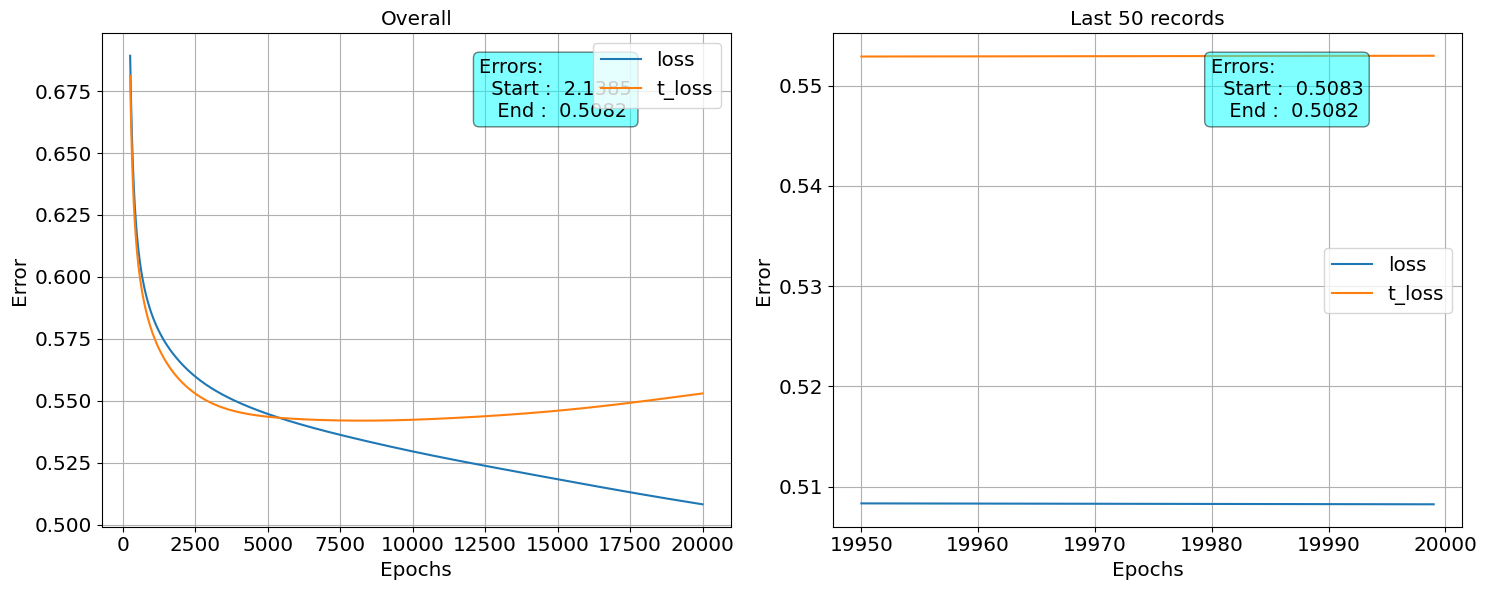

In [77]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]

loss_df[250:].plot(x = 'epoch', y = ['loss', 't_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['loss', 't_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[-l_range]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [80]:
loss_df[loss_df['t_loss'] == (loss_df['t_loss'].min())]

,epoch,loss,t_loss
8182,8265,0.534121,0.542001


## Predictions
### Train Data

In [81]:
# def fn_m
# ake_predicitions(pred_func, X_train):
#     y_pred = pred_func(X)
#     return y_pred

In [82]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

Accuracy score on Train Data : 0.894261899841565


In [83]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.94      0.93      4693
           2       0.85      0.88      0.86      5470
           3       0.87      0.79      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.89      0.89      0.89     14517



### Test Data

In [84]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.8826446280991735


In [85]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.92      1173
           2       0.83      0.87      0.85      1368
           3       0.86      0.76      0.80       684

    accuracy                           0.88      3630
   macro avg       0.90      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



In [86]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[ 405,    0,    0,    0],
       [   0, 1090,   82,    1],
       [   0,   91, 1191,   86],
       [   0,    3,  163,  518]])

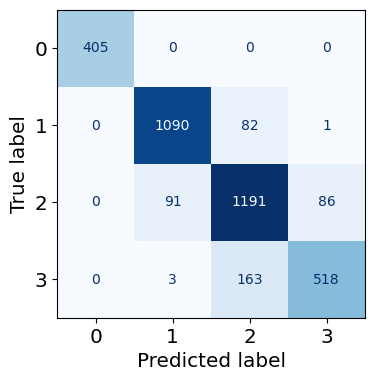

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=labels.values()
                             )

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();